# Lung segmentation with U-net in Keras

Competitions like LUNA (http://luna16.grand-challenge.org) and the Kaggle Data Science Bowl 2017 (https://www.kaggle.com/c/data-science-bowl-2017) involve processing and trying to find lesions in CT images of the lungs. In order to find disease in these images well, it is important to first find the lungs well. This dataset is a collection of 2D and 3D images with manually segmented lungs.

Challenge:
Come up with an algorithm for accurately segmenting lungs and measuring important clinical parameters (lung volume, PD, etc)

Percentile Density (PD)
The PD is the density (in Hounsfield units) the given percentile of pixels fall below in the image. The table includes 5 and 95% for reference. For smokers this value is often high indicating the build up of other things in the lungs.

![image.png](attachment:image.png)



In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

In [2]:
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

Using TensorFlow backend.


In [3]:
IMAGE_LIB = './2d_images/'
MASK_LIB = './2d_masks/'
IMG_HEIGHT, IMG_WIDTH = 32, 32
SEED=42

In [4]:
all_images = [x for x in sorted(os.listdir(IMAGE_LIB)) if x[-4:] == '.tif']

x_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(IMAGE_LIB + name, cv2.IMREAD_UNCHANGED).astype("int16").astype('float32')
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)
    im = (im - np.min(im)) / (np.max(im) - np.min(im))
    x_data[i] = im

y_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(MASK_LIB + name, cv2.IMREAD_UNCHANGED).astype('float32')/255.
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
    y_data[i] = im

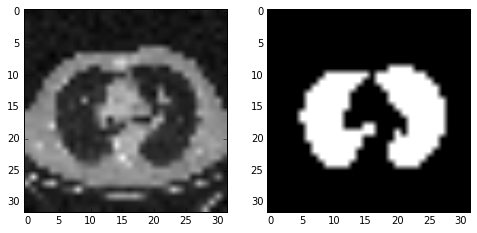

In [5]:
fig, ax = plt.subplots(1,2, figsize = (8,4))
ax[0].imshow(x_data[0], cmap='gray')
ax[1].imshow(y_data[0], cmap='gray')
plt.show()

In [6]:
x_data = x_data[:,:,:,np.newaxis]
y_data = y_data[:,:,:,np.newaxis]
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.5)

# Define and train model

In [7]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [8]:
input_layer = Input(shape=x_train.shape[1:])
c1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=64, kernel_size=(1,1), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c4)
c5 = Conv2D(filters=64, kernel_size=(1,1), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(c5), c4], axis=-1)
l = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c3], axis=-1)
l = Conv2D(filters=48, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Dropout(0.25)(l)
l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.25)(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = Model(input_layer, output_layer)
            

In [9]:
model.summary() 

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 32, 32, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 32, 32, 8)     80          input_1[0][0]                    
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 16, 16, 8)     0           conv2d_1[0][0]                   
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 16, 16, 16)    1168        max_pooling2d_1[0][0]            
___________________________________________________________________________________________

In [10]:
def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(x_train, x_train, batch_size, seed=SEED)
    mask_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(y_train, y_train, batch_size, seed=SEED)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

By using the same RNG seed in both calls to ImageDataGenerator, we should get images and masks that correspond to each other. Let's check this, to be safe.

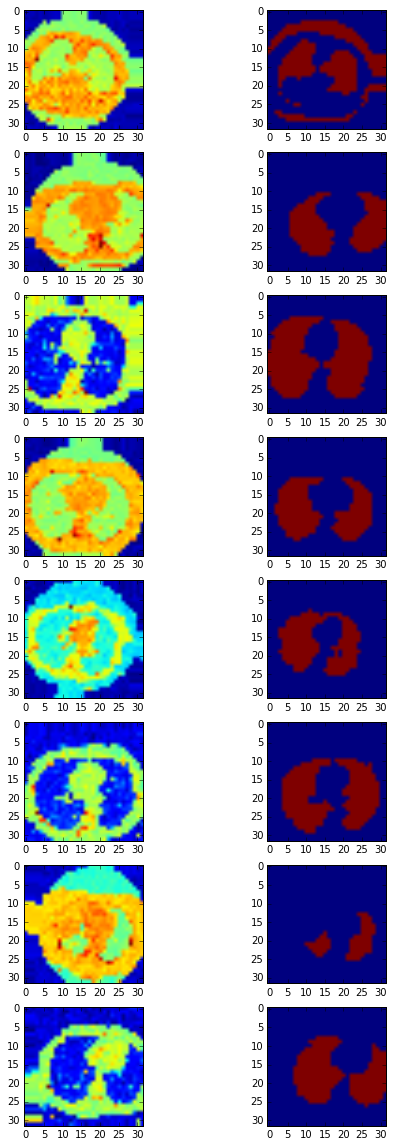

In [11]:
image_batch, mask_batch = next(my_generator(x_train, y_train, 8))
fix, ax = plt.subplots(8,2, figsize=(8,20))
for i in range(8):
    ax[i,0].imshow(image_batch[i,:,:,0])
    ax[i,1].imshow(mask_batch[i,:,:,0])
plt.show()

In [12]:
model.compile(optimizer=Adam(2e-4), loss='binary_crossentropy', metrics=[dice_coef])

weight_saver = ModelCheckpoint('lung.h5', monitor='val_dice_coef', 
                                              save_best_only=True, save_weights_only=True)

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)


In [13]:
hist = model.fit_generator(my_generator(x_train, y_train, 8),
                           steps_per_epoch = 200,
                           validation_data = (x_val, y_val),
                           epochs=30, verbose=2,
                           callbacks = [weight_saver, annealer])

Epoch 1/30
3s - loss: 0.3294 - dice_coef: 0.5486 - val_loss: 0.1443 - val_dice_coef: 0.8245
Epoch 2/30
2s - loss: 0.1400 - dice_coef: 0.8322 - val_loss: 0.0953 - val_dice_coef: 0.8796
Epoch 3/30
2s - loss: 0.1230 - dice_coef: 0.8578 - val_loss: 0.0909 - val_dice_coef: 0.8870
Epoch 4/30
2s - loss: 0.1165 - dice_coef: 0.8665 - val_loss: 0.0828 - val_dice_coef: 0.8925
Epoch 5/30
2s - loss: 0.1094 - dice_coef: 0.8732 - val_loss: 0.0799 - val_dice_coef: 0.8970
Epoch 6/30
2s - loss: 0.1051 - dice_coef: 0.8768 - val_loss: 0.0760 - val_dice_coef: 0.9047
Epoch 7/30
2s - loss: 0.1038 - dice_coef: 0.8800 - val_loss: 0.0750 - val_dice_coef: 0.8997
Epoch 8/30
2s - loss: 0.1006 - dice_coef: 0.8819 - val_loss: 0.0731 - val_dice_coef: 0.9040
Epoch 9/30
2s - loss: 0.0987 - dice_coef: 0.8842 - val_loss: 0.0730 - val_dice_coef: 0.9059
Epoch 10/30
2s - loss: 0.0975 - dice_coef: 0.8853 - val_loss: 0.0739 - val_dice_coef: 0.9011
Epoch 11/30
2s - loss: 0.0943 - dice_coef: 0.8880 - val_loss: 0.0713 - val_dice

# Evaluate

In [14]:
model.load_weights('lung.h5')

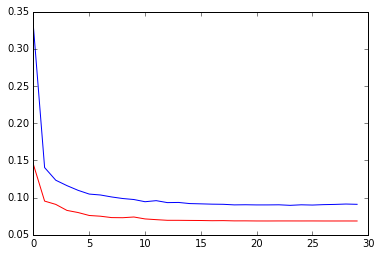

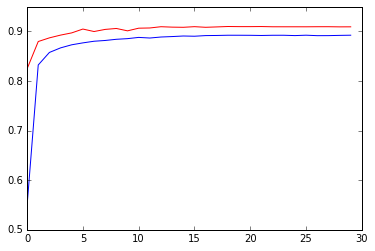

In [15]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['dice_coef'], color='b')
plt.plot(hist.history['val_dice_coef'], color='r')
plt.show()

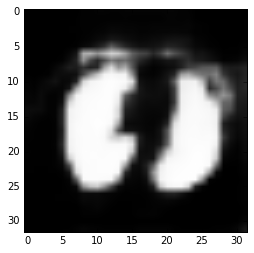

In [16]:
plt.imshow(model.predict(x_val[10].reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))[0,:,:,0], cmap='gray')

In [17]:
x_val.shape

(134, 32, 32, 1)

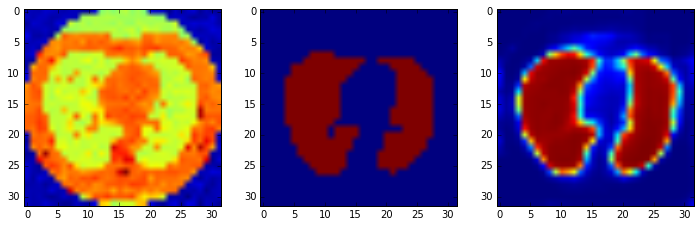

In [18]:
y_hat = model.predict(x_val)
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(x_val[0,:,:,0]) #, cmap='gray')
ax[1].imshow(y_val[0,:,:,0])
ax[2].imshow(y_hat[0,:,:,0])

In [ ]:
len(x_train)